## 0. Required Packages

In [5]:
import pandas as pd
import numpy as np
import scipy.stats.qmc as qmc
import matplotlib.pyplot as plt
from scipy.stats import norm
import mosek
np.random.seed(1234) # seed!

## 1. (Quasi-)Monte Carlo Method

### Random Number Generation Examples

In [35]:
# pseudo-random numbers
sample_pcg = np.random.rand(8, 1) # 8 numbers with dimension 1
sample_pcg

array([[0.19151945],
       [0.62210877],
       [0.43772774],
       [0.78535858],
       [0.77997581],
       [0.27259261],
       [0.27646426],
       [0.80187218]])

In [45]:
# multivariate normal from pseudo-random numbers
sample_mvtnorm_pcg = np.random.multivariate_normal(mean = [1,0], cov = [[1, 0.25], [0.25, 1]], size = 8)
sample_mvtnorm_pcg 

array([[ 1.35661847, -1.10202291],
       [ 0.05880509, -1.32411371],
       [ 1.02640128,  1.11294954],
       [ 0.71022514, -1.06935376],
       [ 2.36094938, -1.38576752],
       [-0.51662347, -0.30174267],
       [ 1.48409184, -1.99142964],
       [ 1.26281412,  0.26540858]])

In [29]:
# Sobol sequence
sampler_sobol = qmc.Sobol(d = 1, seed = 1234)
sample_sobol = sampler_sobol.random_base2(m = 3) # draw 2^m points
sample_sobol 

array([[0.99361137],
       [0.14043246],
       [0.39267315],
       [0.72326729],
       [0.5791784 ],
       [0.28874541],
       [0.05710433],
       [0.82495612]])

In [30]:
# Halton sequence
sampler_halton = qmc.Halton(d = 1, seed = 1234)
sample_halton = sampler_halton.random(n = 8)
sample_halton

array([[0.56210103],
       [0.06210103],
       [0.81210103],
       [0.31210103],
       [0.68710103],
       [0.18710103],
       [0.93710103],
       [0.43710103]])

In [31]:
# Multivariate Normal by Sobol sequence (default)
dist_mvtnorm = qmc.MultivariateNormalQMC(mean = [1, 0], cov = [[1, 0.25], [0.25, 1]], seed = 1234)
sample_mvtnorm = dist_mvtnorm.random(n = 8)
sample_mvtnorm

array([[ 3.48991803,  0.06849223],
       [ 0.3858241 ,  0.05779466],
       [-0.67913872, -1.30423635],
       [ 1.49671832,  1.63139391],
       [ 1.10229634, -1.57315105],
       [ 0.13004198,  0.67206646],
       [ 0.99859291, -0.21004687],
       [ 1.73126045,  0.70521166]])

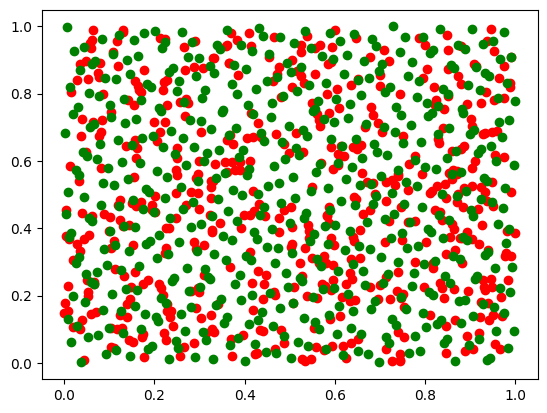

In [58]:
# difference of two RNGs
sample_pseudo_1 = np.random.rand(512, 2)
sample_pseudo_2 = qmc.Sobol(d = 2, seed = 1234).random_base2(m = 9)
plt.scatter(sample_pseudo_1[:,0], sample_pseudo_1[:,1], color = 'red')
plt.scatter(sample_pseudo_2[:,0], sample_pseudo_2[:,1], color = 'green')
plt.show() 

### Pricing of European Options by (Quasi-)Monte Carlo Method

In [210]:
# constants
T = 1
r = 0.2
S_0 = 1
sigma = 0.5
K = 1.2
np.random.seed(1234)

normmake = qmc.MultivariateNormalQMC(mean = (r - 0.5 * np.power(sigma, 2))*T, cov = np.power(sigma, 2) * T, seed = 1234)

def positivemean(list):
    n = len(list)
    sum = 0
    for i in range(n):
        if list[i] > 0:
            sum = sum + list[i]

    return(sum / n)

def flatten(xss):
    return [x for xs in xss for x in xs]

In [211]:
# stochastic simulation
M = 40
pseudo_price = [0] * M
quasi_price = [0] * M
numofsamples = [0] * M

for jj in range(M):
    N = jj * 100 + 100
    numofsamples[jj] = N
    pseudo = np.exp(np.random.normal(loc = (r - 0.5 * np.power(sigma, 2))*T, scale = sigma * np.sqrt(T), size = N))
    quasi = flatten(np.exp(normmake.random(n = N)))
    
    pseudo_price[jj] = np.exp(-r * T) * positivemean(np.subtract(pseudo, K))
    quasi_price[jj] = np.exp(-r * T) * positivemean(np.subtract(quasi, K))


c:\Users\kwonk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [212]:
# BS formula
d1 = (np.log(S_0/K) + (r + np.power(sigma, 2)/2)*T)/(sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
V_0 = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) # 0.20456432827161786

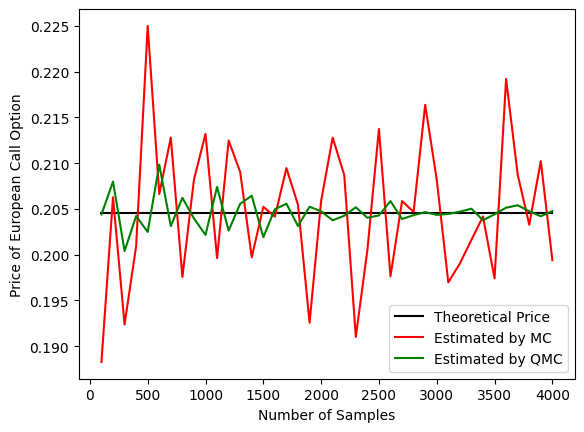

In [213]:
# plot
plt.plot(numofsamples, [V_0] * M, color = "black", label = "Theoretical Price")
plt.plot(numofsamples, pseudo_price, color = "red", label = "Estimated by MC")
plt.plot(numofsamples, quasi_price, color = "green", label = "Estimated by QMC")
plt.legend()
plt.xlabel("Number of Samples")
plt.ylabel("Price of European Call Option")
plt.show()

## 2. Generation of Stochastic Processes

### GBM

In [344]:
# generation of GBM
dt = 1/100

def GBM(dt, T, r, sigma):
    n = int(T/dt)
    z = np.random.normal(loc = 0, scale = 1, size = n)
    x = [0] * (n + 1)
    w = [0] * n
    for j in range(n):
        for k in range(j):
            w[j] = w[j] + np.sqrt(dt) * z[k]
    
    x[0] = S_0
    for j in range(n):
        x[j+1] = np.exp((r - 0.5 * np.power(sigma, 2)) * (j+1) * dt + sigma * w[j])
    return(x)

In [271]:
time = [dt * ws for ws in list(range(int(T/dt) + 1))]
x1 = GBM(dt, T, r, sigma)
x2 = GBM(dt, T, r, sigma)
x3 = GBM(dt, T, r, sigma)
x4 = GBM(dt, T, r, sigma)
x5 = GBM(dt, T, r, sigma)
x6 = GBM(dt, T, r, sigma)
x7 = GBM(dt, T, r, sigma)

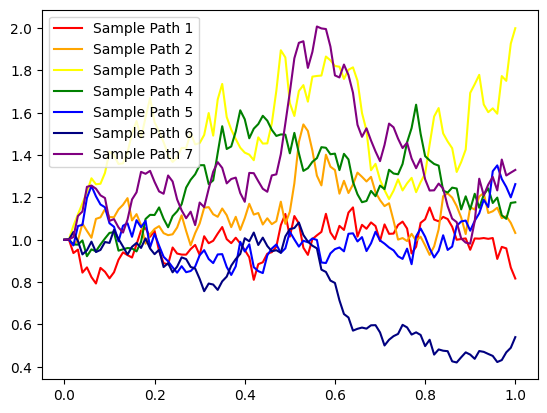

In [272]:
plt.plot(time, x1, color = "red", label = "Sample Path 1")
plt.plot(time, x2, color = "orange", label = "Sample Path 2")
plt.plot(time, x3, color = "yellow", label = "Sample Path 3")
plt.plot(time, x4, color = "green", label = "Sample Path 4")
plt.plot(time, x5, color = "blue", label = "Sample Path 5")
plt.plot(time, x6, color = "navy", label = "Sample Path 6")
plt.plot(time, x7, color = "purple", label = "Sample Path 7")
plt.legend()
plt.show()

### Barrier Option

In [337]:
L = 0.7

def barrierpayoff(S_T, m_T, L, K):
    return ((m_T > L) * max(S_T - K, 0))

In [346]:
# numerical soln
iteration = 10000
sum = 0
for i in range(iteration):
    # i: iteration number
    x = GBM(dt, T, r, sigma)
    m_T = min(x)
    S_T = x[int(T/dt)]
    payoff = barrierpayoff(S_T, m_T, L, K)
    sum = sum + payoff
print("Estimated Price of Barrier Option:", sum/iteration)
    

Estimated Price of Barrier Option: 0.23576890788980867


In [340]:
# theoretical soln
d1 = (np.log(S_0/K) + (r + np.power(sigma, 2)/2)*T)/(sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
d3 = (np.log(np.power(L, 2)/(S_0 * K)) + (r + np.power(sigma, 2)/2)*T)/(sigma * np.sqrt(T))
d4 = d3 - sigma * np.sqrt(T)

V_0_barrier = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)\
    - L * np.power(L/S_0, 2*r/np.power(sigma, 2)) * norm.cdf(d3)\
        + K * np.exp(-r * T) * np.power(L/S_0, 2*r/np.power(sigma, 2) - 1) * norm.cdf(d4)
V_0_barrier

0.1943251283791747

제가 뭔가 어디서 잘못 쳐서? 혹은 수렴 속도가 느려서? 뭔가 수렴이 잘 되지는 않는데, 오류 발견하시면 알려주세요~ 아마 어딘가에서 뭔가를 잘못 친 것 같기도... 합니다.

## 3. Numerical Optimization

### Tutorial

$$
\begin{cases} \text{minimize} & x\\ \text{subject to} & 2.0 \le x \le 3.0\end{cases}
$$

In [2]:
with Env() as env:                            # Create Environment
  with env.Task(0, 1) as task:                # Create Task
    task.appendvars(1)                          # 1 variable x
    task.putcj(0, 1.0)                          # c_0 = 1.0
    task.putvarbound(0, boundkey.ra, 2.0, 3.0)  # 2.0 <= x <= 3.0
    task.putobjsense(objsense.minimize)         # minimize

    task.optimize()                           # Optimize

    x = task.getxx(soltype.itr)               # Get solution
    print("Solution x = {}".format(x[0]))     # Print solution

Solution x = 2.0


### Linear Programming

Task: 
$$
\begin{cases} \text{minimize} & 5x_1 + 6x_2 + 11x_3\\ \text{subject to} & x_1 + x_2 + 2x_3\ge 15\\ & 10 \ge x_1 \ge 0\\ & 7 \ge x_2 \ge 0 \\ & 2 \ge x_3 \ge 0 \end{cases}
$$

In [22]:
import sys
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()

with mosek.Task() as task:
    task.set_Stream(mosek.streamtype.log, streamprinter)
    task.appendcons(1) # linear constraint
    task.appendvars(3) # three variables
    btx = [mosek.boundkey.ra, mosek.boundkey.ra, mosek.boundkey.ra]
    blx = [0.0, 0.0, 0.0]
    bux = [10, 7, 2] # boundary constraints
    asub = [[0], [0], [0]] # sparse matrix form
    aval = [[1.0], [1.0], [2.0]]
    c = [5.0, 6.0, 11.0] # objective coefficients
    
    for j in range(3):
        task.putcj(j, c[j])
        task.putvarbound(j, btx[j], blx[j], bux[j])
        task.putacol(j, asub[j], aval[j])
    task.putconbound(0, mosek.boundkey.lo, 15, float('inf')) # constraint bound
    
    task.putobjsense(mosek.objsense.minimize)
    task.optimize()
    solsta = task.getsolsta(mosek.soltype.bas) # solution status

    if (solsta == mosek.solsta.optimal):
        xx = task.getxx(mosek.soltype.bas)
            
        print("Optimal solution: ")
        for i in range(3):
            print("x[" + str(i) + "]=" + str(xx[i]))
            
    cost = task.getprimalobj(mosek.soltype.bas)
    print("Minimal cost:", cost)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 1               
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 3               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 0                 time                   : 0.00            
Lin. dep.  - primal attempts        : 0                 successes              : 0               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.  

### Quadratic Programming

Task: 
$$\begin{cases}
		\text{maximize} & r^Tx - \lambda x^T\Sigma x\\
		\text{subject to} & 1^Tx = 1\\
		& x \ge 0
	\end{cases}$$

where $x \in \mathbb{R}^3$, $\lambda = 0.5$ and 
$$
r = \begin{pmatrix} 0.09 \\ 0.16 \\ 0.25\end{pmatrix}, \quad \Sigma = \begin{pmatrix} 1.0 & 0.4 & -0.8\\ 0.4 & 2.0 & -1.5\\ -0.8 & -1.5 & 3.0 \end{pmatrix}
$$

In [31]:
with mosek.Env() as env:
    # Attach a printer to the environment
    env.set_Stream(mosek.streamtype.log, streamprinter)
    # Create a task
    with env.Task() as task:
        task.set_Stream(mosek.streamtype.log, streamprinter)
        # Set up and input bounds and linear coefficients
        numvar = 3
        bkx = [mosek.boundkey.lo] * numvar
        blx = [0.0] * numvar
        bux = [0.0] * numvar # lo do not use bux
        c = [0.09, 0.16, 0.25]

        numvar = len(bkx)
        
        # Append 'numvar' variables.
        # The variables will initially be fixed at zero (x=0).
        task.appendvars(numvar)

        # constranints
        task.appendcons(1)
        task.putarow(0, range(numvar), [1]*numvar)
        task.putconbound(0, mosek.boundkey.fx, 1.0, 1.0)

        for j in range(numvar):
            # Set the linear term c_j in the objective.
            task.putcj(j, c[j])
            # Set the bounds on variable j
            # blx[j] <= x_j <= bux[j]
            task.putvarbound(j, bkx[j], blx[j], bux[j])

        # Set up and input quadratic objective
        qsubi = [0, 1, 1, 2, 2, 2]
        qsubj = [0, 0, 1, 0, 1, 2]
        qval = [-0.5 * x for x in[1.0, 0.4, 2.0, -0.8, -1.5, 3.0]]

        task.putqobj(qsubi, qsubj, qval)

        # Input the objective sense (minimize/maximize)
        task.putobjsense(mosek.objsense.maximize)

        # Optimize
        task.optimize()
        # Print a summary containing information
        # about the solution for debugging purposes
        task.solutionsummary(mosek.streamtype.msg)

        prosta = task.getprosta(mosek.soltype.itr)
        solsta = task.getsolsta(mosek.soltype.itr)

        # Output a solution
        xx = task.getxx(mosek.soltype.itr)

        if solsta == mosek.solsta.optimal:
            print("Optimal solution: %s" % xx)
        elif solsta == mosek.solsta.dual_infeas_cer:
            print("Primal or dual infeasibility.\n")
        elif solsta == mosek.solsta.prim_infeas_cer:
            print("Primal or dual infeasibility.\n")
        elif mosek.solsta.unknown:
            print("Unknown solution status")
        else:
            print("Other solution status")


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : QO (quadratic optimization problem)
  Constraints            : 1               
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 3               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Quadratic to conic reformulation started.
Quadratic to conic reformulation terminated. Time: 0.00    
Presolve started.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time    